# Spam Detection Using TensorFlow

In [49]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io

 Load and Clean Dataset

In [50]:
# Load Dataset
dataset = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
dataset.columns = ['Category', 'Message']
dataset['Category'] = dataset['Category'].map({'ham': 0, 'spam': 1})

In [51]:

# Prepare Sentences and Labels
sentences = dataset['Message'].tolist()
labels = dataset['Category'].tolist()

Split Dataset into Train and Test Sets

In [52]:
# Split Dataset
training_size = int(len(sentences) * 0.8)
training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = np.array(labels[:training_size])
testing_labels = np.array(labels[training_size:])

Tokenize and Pad the Text Data

In [53]:
# Tokenization & Padding
vocab_size = 600
embedding_dim = 16
max_length = 60
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

In [54]:
word_index = tokenizer.word_index
reverse_word_index = {v: k for k, v in word_index.items()}

In [55]:
train_sequences = tokenizer.texts_to_sequences(training_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(testing_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [56]:
# Function to decode a padded sequence
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

 Define and Build the Model

In [61]:
# Model Definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [63]:
# Build model explicitly to avoid 'unbuilt' warning
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 60, 16)              │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_8           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 6)                   │             102 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,709 (37.93 KB)

 Trainable params: 9,709 (37.93 KB)

 Non-trainable params: 0 (0.00 B)

Compile and Train the Model

In [65]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [66]:
# Model Training
num_epochs = 30
history = model.fit(train_padded, training_labels, epochs=num_epochs,
                    validation_data=(test_padded, testing_labels), verbose=2)

Epoch 1/30
140/140 - 2s - 15ms/step - accuracy: 0.8649 - loss: 0.3633 - val_accuracy: 0.8700 - val_loss: 0.3148
Epoch 2/30
140/140 - 1s - 9ms/step - accuracy: 0.8620 - loss: 0.2956 - val_accuracy: 0.8717 - val_loss: 0.2471
Epoch 3/30
140/140 - 1s - 7ms/step - accuracy: 0.8954 - loss: 0.2310 - val_accuracy: 0.9291 - val_loss: 0.1912
Epoch 4/30
140/140 - 0s - 3ms/step - accuracy: 0.9365 - loss: 0.1815 - val_accuracy: 0.9552 - val_loss: 0.1490
Epoch 5/30
140/140 - 1s - 4ms/step - accuracy: 0.9571 - loss: 0.1440 - val_accuracy: 0.9704 - val_loss: 0.1188
Epoch 6/30
140/140 - 1s - 7ms/step - accuracy: 0.9677 - loss: 0.1150 - val_accuracy: 0.9758 - val_loss: 0.0957
Epoch 7/30
140/140 - 2s - 13ms/step - accuracy: 0.9729 - loss: 0.0949 - val_accuracy: 0.9758 - val_loss: 0.0799
Epoch 8/30
140/140 - 2s - 12ms/step - accuracy: 0.9753 - loss: 0.0818 - val_accuracy: 0.9821 - val_loss: 0.0707
Epoch 9/30
140/140 - 1s - 9ms/step - accuracy: 0.9787 - loss: 0.0731 - val_accuracy: 0.9812 - val_loss: 0.064

Visualize the Training Loss

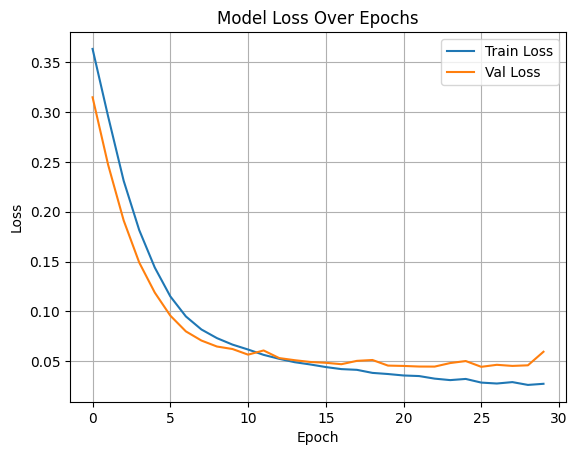

In [74]:
# Plot Training History
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Decode Sample Input

In [68]:
# Extract and Save Embeddings
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]  # Shape: (vocab_size, embedding_dim)

Export Embedding Vectors

In [69]:
# Save word embeddings and metadata
with io.open('vecs.tsv', 'w', encoding='utf-8') as out_v, io.open('meta.tsv', 'w', encoding='utf-8') as out_m:
    for word_num in range(1, vocab_size):
        word = reverse_word_index.get(word_num, "<UNK>")
        embedding = weights[word_num]
        out_m.write(f"{word}\n")
        out_v.write('\t'.join([str(x) for x in embedding]) + "\n")


print(f"Embedding weights shape: {weights.shape}")  # (vocab_size, embedding_dim)

Embedding weights shape: (600, 16)


Make Predictions on Custom Messages

In [70]:
# Spam Prediction on Sample Messages
sample_messages = [
    'Greg, can you call me back once you get this?',
    'Congrats on your new iPhone! Click here to claim your prize...',
    'Really like that new photo of you',
    'Did you hear the news today? Terrible what has happened...',
    'Attend this free COVID webinar today: Book your session now...',
    'Are you coming to the party tonight?',
    'Your parcel has gone missing',
    'Do not forget to bring friends!',
    'You have won a million dollars! Fill out your bank details here...',
    'Looking forward to seeing you again'
]

sample_sequences = tokenizer.texts_to_sequences(sample_messages)
sample_padded = pad_sequences(sample_sequences, maxlen=max_length, padding=padding_type)

predictions = model.predict(sample_padded)

# Display Results
for message, pred in zip(sample_messages, predictions):
    label = "SPAM" if pred > 0.5 else "HAM"
    print(f"\nMessage: {message}")
    print(f"Prediction Score: {pred[0]:.4f} -> {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step

Message: Greg, can you call me back once you get this?
Prediction Score: 0.1323 -> HAM

Message: Congrats on your new iPhone! Click here to claim your prize...
Prediction Score: 0.9680 -> SPAM

Message: Really like that new photo of you
Prediction Score: 0.0234 -> HAM

Message: Did you hear the news today? Terrible what has happened...
Prediction Score: 0.0516 -> HAM

Message: Attend this free COVID webinar today: Book your session now...
Prediction Score: 0.7884 -> SPAM

Message: Are you coming to the party tonight?
Prediction Score: 0.0191 -> HAM

Message: Your parcel has gone missing
Prediction Score: 0.0270 -> HAM

Message: Do not forget to bring friends!
Prediction Score: 0.0035 -> HAM

Message: You have won a million dollars! Fill out your bank details here...
Prediction Score: 0.7410 -> SPAM

Message: Looking forward to seeing you again
Prediction Score: 0.1125 -> HAM
